# vdl Depth and Class Constrained Diffusion
- **Name:** Nils Fahrni
- **Date:** 07.01.2025

## Dataset Preparation

- 894 classes -> 18 classes

In [1]:
from data.nyuv2 import NYUDepthV2
from torchvision import transforms
from torch.utils.data import DataLoader
import torch

mean = [0.5105, 0.4662, 0.4438]
std = [0.2273, 0.2275, 0.2409]

image_t = transforms.Compose([
    transforms.CenterCrop(400),
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

crop_t = transforms.Compose([
    transforms.CenterCrop(400),
    transforms.Resize(64),
    transforms.ToTensor(),
])

dataset = NYUDepthV2(root='data', 
                     download=True, 
                     preload=False, 
                     image_transform=image_t, 
                     seg_transform=crop_t, 
                     depth_transform=crop_t, 
                     filtered_classes=[5, 11, 21, 26, 2, 3, 7, 64, 144, 19, 119, 157, 28, 55, 15, 59, 4, 83])

dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=4)

Dataset already exists, skipping download.


In [2]:
from data import split_dataset

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
import torch.nn as nn
import wandb
import matplotlib.pyplot as plt
import copy
import os
from diffusion import Diffusion
import hydra
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

class Analyzer:
    def __init__(self, model: nn.Module, device: str="cpu", project_name: str="vdl", entity_name: str="okaynils", diffusion_params: dict=None):
        self.model = model
        self.ema_model = None
        self.device = device
        self.project_name = project_name
        self.entity_name = entity_name
        self.history = None
        self.run_name = None
        self.elapsed_time = None
        
        if diffusion_params == None:
            diffusion_params = OmegaConf.load('configs/trainer/default.yaml').diffusion
            
        self.diffusion = Diffusion(
            noise_steps=diffusion_params.noise_steps,
            beta_start=diffusion_params.beta_start,
            beta_end=diffusion_params.beta_end,
            img_size=diffusion_params.img_size,
            device=self.device
        )
    
    def model_receipt(self):
        total_params = sum(p.numel() for p in self.model.parameters())
        trainable_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        non_trainable_params = total_params - trainable_params
        device = next(self.model.parameters()).device
        
        print(f"--- Model Receipt for {self.model.__class__.__name__} ---")
        if self.elapsed_time:
            print(f"\nTraining Time: {self.elapsed_time/60**2:.2f} hours")
        print(f"Total parameters: {total_params}")
        print(f"Trainable parameters: {trainable_params}")
        print(f"Non-trainable parameters: {non_trainable_params}")
        print(f"Device: {device}")
        
        print("\nModel Architecture:\n")
        print(self.model)
        
    def plot(self, run_id: str):
        if self.history is None:
            self._fetch_data(run_id)
        
        train_loss = [entry['train_loss'] for entry in self.history if entry['train_loss'] is not None]
        val_loss = [entry['val_loss'] for entry in self.history if entry['val_loss'] is not None]
        fid = [entry['FID'] for entry in self.history if entry['FID'] is not None]
        psnr = [entry['PSNR'] for entry in self.history if entry['PSNR'] is not None]

        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        axes[0].plot(train_loss, label='Train Loss', marker='o')
        axes[0].plot(val_loss, label='Validation Loss', marker='x')
        axes[0].set_title('Training and Validation Loss')
        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('MSE Loss')
        axes[0].legend()
        axes[0].grid(True)

        fid_epochs = [i * 50 for i in range(len(fid))]
        axes[1].plot(fid_epochs, fid, label='FID', marker='o', color='orange')
        axes[1].set_title('FID Metric')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('FID Value')
        axes[1].legend()
        axes[1].grid(True)

        psnr_epochs = [i * 50 for i in range(len(psnr))]
        axes[2].plot(psnr_epochs, psnr, label='PSNR', marker='x', color='green')
        axes[2].set_title('PSNR Metric')
        axes[2].set_xlabel('Epoch')
        axes[2].set_ylabel('PSNR Value')
        axes[2].legend()
        axes[2].grid(True)

        fig.suptitle(f'Run: {self.run_name}', fontsize=16)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()
        
    def sample_images(self, run_id: str,  class_vects: torch.tensor, depth_vects: torch.tensor, n_samples: int=5):
        self._load_model_weights(run_id)
        
        if len(class_vects) != n_samples:
            class_vects = class_vects.repeat(n_samples, 1)
        if len(depth_vects) != n_samples:
            depth_vects = depth_vects.repeat(n_samples, 1)
        
        default_sampled_images = self.diffusion.sample(self.model, n_samples, class_vects.to(self.device), depth_vects.to(self.device))
        ema_sampled_images = self.diffusion.sample(self.ema_model, n_samples, class_vects.to(self.device), depth_vects.to(self.device))
    
        print("Default Model Samples:")
        print(f'ema: {ema_sampled_images[0].shape}')
        print(f'default: {default_sampled_images[0].shape}')
        
    def _get_model_path(self, run_id: str):
        models = os.listdir('models')
        model_path = None
        ema_model_path = None
        for model in models:
            run_name = model.split('_')
            if len(run_name) > 1:
                if model.split('_')[-2] == 'ema' and run_name[-1].split('.')[0] == run_id:
                    ema_model_path = model
                    continue
                if run_name[-1].split('.')[0] == run_id:
                    model_path = model
        return model_path, ema_model_path
        
    def _load_model_weights(self, run_id: str):
        model_path, ema_model_path = self._get_model_path(run_id)
        
        self.ema_model = copy.deepcopy(self.model).eval().requires_grad_(False)
        self.model.load_state_dict(torch.load(f'models/{model_path}', map_location=device, weights_only=True))
        self.model.to(self.device)
        if ema_model_path:
            self.ema_model.load_state_dict(torch.load(f'models/{ema_model_path}', map_location=device, weights_only=True))
            self.model.to(self.device)
    
    
    def _fetch_data(self, run_id: str):
        api = wandb.Api()
        try:
            run = api.run(f"{self.entity_name}/{self.project_name}/{run_id}")
            self.run_name = run.name
            self.elapsed_time = run.summary.get('_runtime', None)
            self.history = run.history(pandas=False)
        except wandb.errors.CommError as e:
            raise ValueError(f"Error fetching run: {e}")


In [8]:
import torch
from core import UNet_Attn

# Define model parameters
c_in = 3 # Number of input channels (e.g., RGB image)
c_out = 3  # Number of output channels
H, W = 64, 64  # Height and width of input image
batch_size = 4  # Batch size
time_dim = 256  # Dimensionality of time encoding
num_classes = 18  # Number of classes (if applicable)

# Create sample inputs
x = torch.randn(batch_size, c_in, H, W)  # Input image tensor
t = torch.randint(0, 1000, (batch_size,))  # Random time steps
class_vector = torch.randn(batch_size, num_classes)  # Random class embeddings
depth_vector = torch.randn(batch_size, num_classes)  # Random depth embeddings

# Initialize the model
model = UNet_Attn(
    c_in=c_in,
    c_out=c_out,
    time_dim=time_dim,
    num_classes=num_classes,
    device="cpu",  # Change to "cuda" if using GPU
    dropout_prob=0.1,
)

# Run the model in evaluation mode
model.eval()
with torch.no_grad():
    output = model(x, t, class_vector, depth_vector)

# Check output shape
print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")


Input shape: torch.Size([4, 3, 64, 64])
Output shape: torch.Size([4, 3, 64, 64])


In [7]:
import torch
from core import UNet_Attn
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet_Attn(num_classes=18, dropout_prob=0.2, device=device).to(device)
#ema_model = copy.deepcopy(model).eval().requires_grad_(False)

#ema_model.load_state_dict(torch.load('models/unet_attn_dropout_0.2_ema_o6mtkrvr.pth', map_location=device))


TypeError: UNet_Attn.forward() missing 3 required positional arguments: 't', 'class_vector', and 'depth_vector'

In [188]:
torch.randn(5, 18).unsqueeze(0).shape

torch.Size([1, 5, 18])

tensor([0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0.])
tensor([0.0000, 3.5806, 3.5806, 3.5806, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        3.5806, 3.5806, 0.0000, 0.0000, 0.0000, 3.5806, 0.0000, 0.0000, 0.0000])


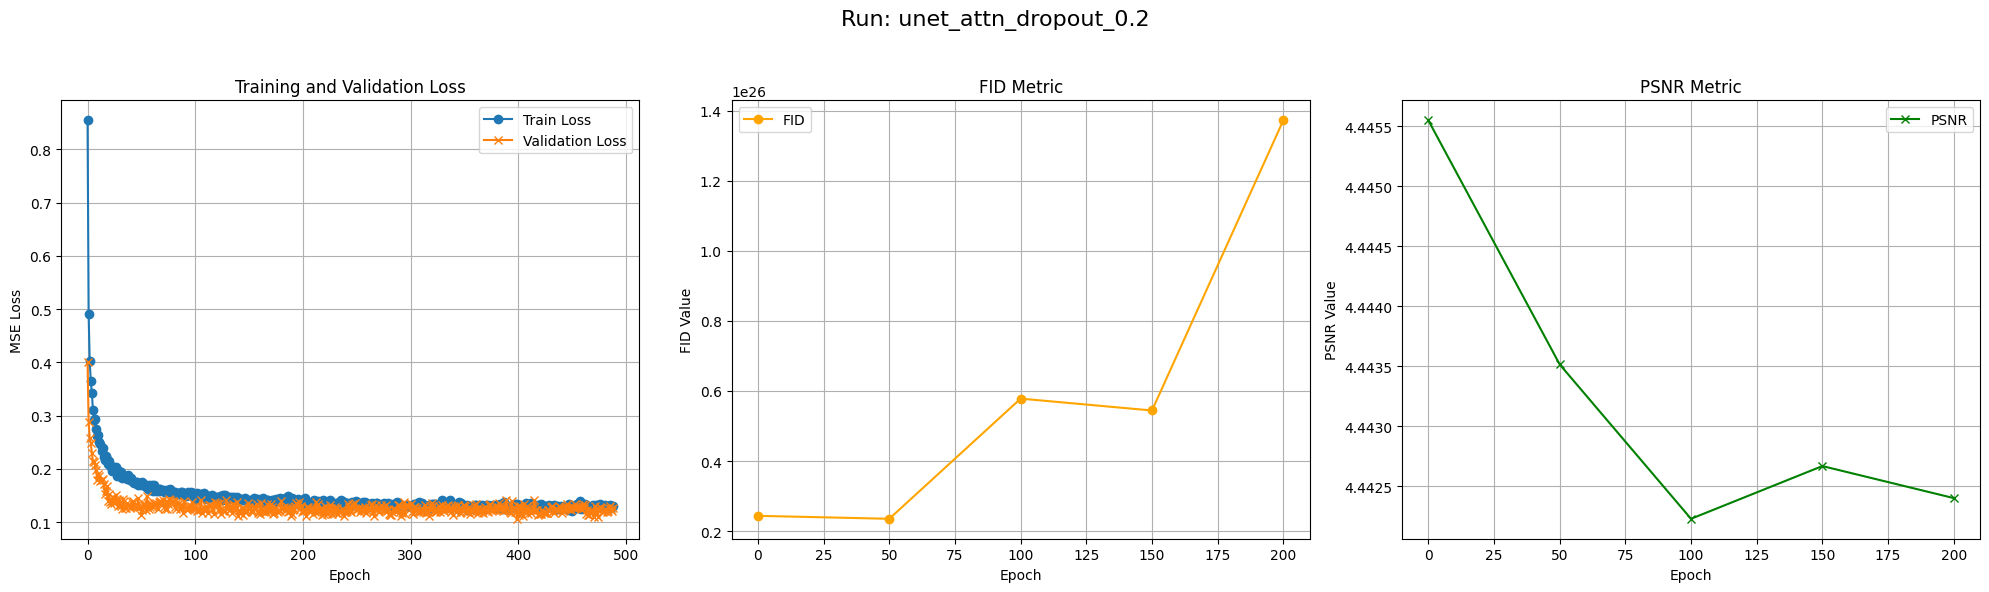

--- Model Receipt for UNet_Attn ---

Training Time: 6.62 hours
Total parameters: 23539331
Trainable parameters: 23539331
Non-trainable parameters: 0
Device: cuda:0

Model Architecture:

UNet_Attn(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GroupNorm(1, 64, eps=1e-05, affine=True)
      (2): GELU(approximate='none')
      (3): Dropout(p=0.2, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (5): GroupNorm(1, 64, eps=1e-05, affine=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GroupNorm(1, 64, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
 

06:30:54 - INFO: Sampling 5 new images from UNet_Attn...
999it [01:13, 13.55it/s]
06:32:08 - INFO: Sampling 5 new images from UNet_Attn...
999it [01:20, 12.48it/s]

Default Model Samples:
ema: torch.Size([3, 64, 64])
default: torch.Size([3, 64, 64])


In [189]:
class_vec = torch.randint(0, 2, (18,), dtype=torch.float32)
# create depth vector of size 18 and put random numbers where class vector is 1
depth_vec = torch.zeros(18, dtype=torch.float32)
# random depth float value between 1 and 5
random_depth_value = torch.rand(1) * 4 + 1
depth_vec[class_vec == 1] = random_depth_value

print(class_vec)
print(depth_vec)
analyzer = Analyzer(model, device)
analyzer.plot('o6mtkrvr')
analyzer.model_receipt()
analyzer.sample_images('o6mtkrvr', class_vec, depth_vec)

## Modules

In [5]:
from core import UNet_Baseline
from core import UNet_Attn

# Instantiate the model
baseline = UNet_Baseline(num_classes=18, device=device).to(device)
attn = UNet_Attn(num_classes=18, device=device).to(device)

# Dummy inputs
x = torch.randn(1, 3, 64, 64).to(device)
t = torch.randint(0, 1000, (x.shape[0],)).to(device)
class_vector = torch.ones((x.shape[0], 18)).to(device)
depth_vector = torch.zeros((x.shape[0], 18)).to(device)

for net in [baseline, attn]:
    output = net(x, t, class_vector, depth_vector)
    print(f'--- Model: {net.__class__.__name__} ---')
    print(f"Total parameters: {sum(p.numel() for p in net.parameters())}")
    print(f'Input shape: {x.shape}')
    print(f"Output shape: {output.shape}")
    print()

--- Model: UNet_Baseline ---
Total parameters: 1771907
Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 3, 64, 64])

--- Model: UNet_Attn ---
Total parameters: 23539331
Input shape: torch.Size([1, 3, 64, 64])
Output shape: torch.Size([1, 3, 64, 64])



## Diffusion

In [6]:
from diffusion import Diffusion

## Trainer

In [7]:
from trainer import Trainer

In [94]:
train_dataset, val_dataset, test_dataset = split_dataset(dataset[:24], train_ratio=0.7, val_ratio=0.2, test_ratio=0.1)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Testing samples: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

Training samples: 16
Validation samples: 4
Testing samples: 4


In [96]:
from core import UNet_Attn
# import copy here
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = UNet_Attn(num_classes=18, dropout_prob=0.2, device=device).to(device)
ema_model = copy.deepcopy(model).eval().requires_grad_(False)

ema_model.load_state_dict(torch.load('models/unet_attn_dropout_0.2_ema_o6mtkrvr.pth', map_location=device))

C:\Users\fahrn\AppData\Local\Temp\ipykernel_21016\74155036.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ema_model.load_state_dict(torch.load('models/unet_attn_dropou

<All keys matched successfully>

In [135]:
# a 894-dimensional class vector with some 1s and 0s
class_vector = torch.tensor(dataset[0][3]).unsqueeze(0)
depth_vector = torch.tensor(dataset[0][4]).unsqueeze(0)

dataset.resolved_names 

class_vector = torch.tensor([0]*18)
print(dataloader.dataset.resolved_names)

class_vector[0] = 1
class_vector[15] = 1

depth_vector = torch.tensor([0]*18)
depth_vector[0] = 1.3
depth_vector[15] = 3.0

['chair' 'floor' 'wall' 'box' 'bottle' 'cabinet' 'counter' 'picture'
 'lamp' 'table' 'pillow' 'bed' 'door' 'bag' 'paper' 'window' 'ceiling'
 'sofa']


In [136]:
depth_vector

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0])

In [117]:
# vector of rand int between 0 and 1000
t = torch.randint(0, 2, (18,))
t

tensor([0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')

In [11]:
class_vector.shape, depth_vector.shape

(torch.Size([18]), torch.Size([18]))

In [162]:
class_vec = torch.randint(0, 2, (18,), dtype=torch.float32)
# create depth vector of size 18 and put random numbers where class vector is 1
depth_vec = torch.zeros(18, dtype=torch.float32)
# random depth float value between 1 and 5
random_depth_value = torch.rand(1) * 4 + 1
depth_vec[class_vec == 1] = random_depth_value

class_vec, depth_vec

(tensor([1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.]),
 tensor([3.5020, 3.5020, 0.0000, 3.5020, 3.5020, 0.0000, 0.0000, 3.5020, 0.0000,
         3.5020, 0.0000, 3.5020, 3.5020, 3.5020, 0.0000, 0.0000, 0.0000, 0.0000]))

In [151]:
dataset[0][3].shape, depth_vec.shape

((18,), torch.Size([18]))

In [168]:
torch.randn((5,18))

tensor([[-1.3699, -1.3499,  0.2956, -0.2121, -1.0645, -0.2529,  0.1801,  0.8034,
         -0.5629,  1.1299, -0.1499,  1.6647,  0.4075, -0.8150, -0.5623,  0.8271,
          0.8679,  1.7021],
        [ 0.6759, -0.3045,  0.0482,  1.1407,  1.0915, -0.1082,  0.9176, -1.2093,
          0.3622, -0.6764,  0.1202,  0.2775, -1.0146,  1.2761,  1.0258, -0.7102,
         -0.3212,  0.6506],
        [-0.2277, -0.0103, -1.0557,  0.1271,  1.4329, -0.3883, -0.7710, -0.1681,
          0.6162, -0.0086, -1.0318, -0.2279,  0.3163,  0.1782, -1.2993, -0.7808,
          0.8477, -0.4030],
        [ 0.9612,  0.3948, -0.4251, -0.7046,  1.1402,  0.1000,  1.6556,  0.7505,
         -0.8409,  0.2214,  0.5243,  0.3529, -1.5270, -0.3965,  0.3960,  0.4018,
          0.1686, -0.8878],
        [-1.5587,  0.0707,  0.5291, -1.3588, -1.3615, -0.1360,  0.4712, -0.6185,
         -0.6138,  0.3171, -0.3423, -0.0232, -0.1501, -0.5206, -1.0282, -1.4857,
          0.9477,  0.8803]])

In [176]:
diffusion = Diffusion(beta_start=0.0001, beta_end=0.002, device=device)

sampled_images = diffusion.sample(ema_model, 5, torch.randn((5,18)).to(device), torch.randn(5,18).to(device))

05:34:32 - INFO: Sampling 5 new images from UNet_Attn...
999it [00:58, 17.17it/s]


05:51:22 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.6846166..0.5138063].


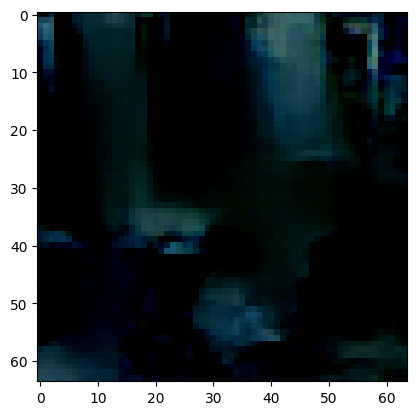

In [181]:
from data import unnormalize

plt.imshow(sampled_images[3].cpu().permute(1, 2, 0))
plt.show()

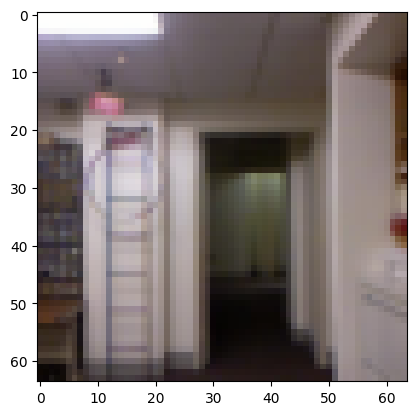

In [16]:
plt.imshow(unnormalize(train_dataset[1][0], mean, std).permute(1, 2, 0))

In [17]:
plot_image(sampled_images[0], mean, std, value_range="[0, 1]")

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.